## RSS

In [0]:
import psycopg2
database = "rssfeed"
hostname="rssfeed.cjgj2uy1bapa.us-east-1.rds.amazonaws.com"
port="5432" 
userid="postgres"
passwrd=""
conn_string = "host="+hostname+" port="+port+" dbname="+database+" user="+userid+" password="+passwrd
conn = psycopg2.connect(conn_string)
conn.autocommit=True
cursor = conn.cursor()

### Query 1: everything in the database

In [0]:
sqlSelect = "SELECT * FROM rss_entities_with_pub";
cursor.execute(sqlSelect);
rows = cursor.fetchall();

In [0]:
len(rows)

5581695

In [0]:
rows[1:10]

[(5871, 'Wozniacki', '2020-01-07T06:23:52+00:00'),
 (5871, 'Tennis Threads Magazine', '2020-01-07T06:23:52+00:00'),
 (13317, 'Nigerian', '2019-12-31T08:00:00+00:00'),
 (13317, 'Nigerian', '2019-12-31T08:00:00+00:00'),
 (5191, 'David Lynch', '2020-01-24T11:34:50+00:00'),
 (5191, 'STUDIOCANAL', '2020-01-24T11:34:50+00:00'),
 (5191, 'Ultra HD', '2020-01-24T11:34:50+00:00'),
 (5191, 'THE ELEPHANT MAN', '2020-01-24T11:34:50+00:00'),
 (5191, 'UK', '2020-01-24T11:34:50+00:00')]

### Query 2: get database column names

In [0]:
cursor.execute("SELECT * FROM rss_entities_with_pub LIMIT 0")
colnames = [desc[0] for desc in cursor.description]
colnames

['publisher_id', 'entity', 'timestamp']

### Query 3: Donald Trump

In [0]:
sqlSelect = "SELECT * FROM rss_entities_with_pub WHERE entity = 'Donald Trump'";
cursor.execute(sqlSelect);
rows_DT = cursor.fetchall();

In [0]:
rows_DT[1:10]

[(8920, 'Donald Trump', '2020-01-24T02:29:25+00:00'),
 (3769, 'Donald Trump', '2020-01-24T09:55:23-05:00'),
 (1086, 'Donald Trump', '2020-01-24T13:47:13+00:00'),
 (12033, 'Donald Trump', '2020-01-23T13:00:00-05:00'),
 (12033, 'Donald Trump', '2020-01-23T13:00:00-05:00'),
 (1143, 'Donald Trump', '2020-01-24T13:50:00+00:00'),
 (14353, 'Donald Trump', '2020-01-23T22:34:23+00:00'),
 (15070, 'Donald Trump', '2020-01-24T03:16:13-05:00'),
 (8969, 'Donald Trump', '2020-01-24T09:29:16+00:00')]

### Group by entity and publisher, count appearances

In [0]:
cursor.execute("SELECT entity, count(*), publisher_id FROM rss_entities_with_pub GROUP BY entity, publisher_id HAVING COUNT(*)>5 ORDER BY COUNT(*) DESC");
rows_e = cursor.fetchall();
rows_e[0:10]

[('Google News', 4801, 13317),
 ('View Entire Post', 4730, 14343),
 ('Dubai', 2318, 11240),
 ('UAE', 1940, 11240),
 ('Paul Oakenfold', 1795, 15471),
 ('London', 1707, 15450),
 ('Facebook', 1617, 635),
 ('Twitter', 1562, 2976),
 ('China', 1457, 3769),
 ('ACU', 1438, 3458)]

### Integrate publisher code with name

In [0]:
## Publisher url codes
import pandas as pd
publishers = pd.read_json('data/rss_feed.json', typ='series')
publishers = publishers.to_dict()
pub = {v: k for k, v in publishers.items()}

In [0]:
rssdf = pd.DataFrame(rows)
rssdf.columns = ['publisher_code','entity','publish_time']
rssdf["publisher"] = rssdf["publisher_code"].map(pub)  
rssdf.head()

,publisher_code,entity,publish_time,publisher
0,5871,Auckland | Coco,2020-01-07T06:23:52+00:00,http://tennisthreads.net/feed
1,5871,Wozniacki,2020-01-07T06:23:52+00:00,http://tennisthreads.net/feed
2,5871,Tennis Threads Magazine,2020-01-07T06:23:52+00:00,http://tennisthreads.net/feed
3,13317,Nigerian,2019-12-31T08:00:00+00:00,https://news.google.com/rss?hl=en-US&gl=US&cei...
4,13317,Nigerian,2019-12-31T08:00:00+00:00,https://news.google.com/rss?hl=en-US&gl=US&cei...


### Which entities are the most popular?

In [0]:
popular = rssdf.groupby(['entity']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(1000)
popular

,entity,counts
246787,China,26717
1262116,US,21405
413019,Facebook,20961
1254818,Twitter,19653
1260615,UK,19052
...,...,...
60985,Alan,398
1314604,Westminster,397
88962,Anfield,397
1114173,Steve Pavlina,396


## Elasticsearch

In [0]:
import json
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
host="https://7771acde721f4a6bafa7cc6819bf7a45.us-east-1.aws.found.io:9243"
username = "onur"
pw = ""
es = Elasticsearch([host], http_auth=(username,pw))

<Elasticsearch([{'host': '7771acde721f4a6bafa7cc6819bf7a45.us-east-1.aws.found.io', 'port': 9243, 'use_ssl': True}])>

In [0]:
res = es.search(
    index="tracking_events_prod",
    body={
        "query": 
        {
            "match": {
                "entity.keyword": "Donald Trump"
            }
        }
    },
    size=1000,
    request_timeout=50
)

print(json.dumps(res,indent=5))

{
     "took": 560,
     "timed_out": false,
     "_shards": {
          "total": 1,
          "successful": 1,
          "skipped": 0,
          "failed": 0
     },
     "hits": {
          "total": {
               "value": 6610,
               "relation": "eq"
          },
          "max_score": 5.9880347,
          "hits": [
               {
                    "_index": "tracking_events_prod",
                    "_type": "tracking_event",
                    "_id": "g8Brjm4BXLoIPyi2vZpR",
                    "_score": 5.9880347,
                    "_source": {
                         "publisher_id": "5d9664316afc51796de5ecb4",
                         "article_id": "5681116",
                         "entity": "Donald Trump",
                         "source": "DESKTOP",
                         "ip_addr": "217.227.236.139",
                         "user_agent_platform": "windows",
                         "user_agent_browser": "chrome",
                         "user_agent_ve

### Get Elasticsearch results into a dataframe

In [0]:
for key, val in res.items():
    print(key, "\n")

took 

timed_out 

_shards 

hits 



In [0]:
for key, val in res['hits'].items():
    print(key, "\n")

total 

max_score 

hits 



In [0]:
elastic_docs = res["hits"]["hits"]
print ("documents returned:", len(elastic_docs))

documents returned: 1000


In [0]:
source_data = []
for num, doc in enumerate(elastic_docs):
    source_data.append(doc["_source"])


In [0]:
fields = {}
for i in range(len(source_data)):
    for key, val in source_data[i].items():
        try:
            fields[key] = np.append(fields[key], val)
        except KeyError:
            fields[key] = np.array([val])

In [0]:
for item in fields:
    print(item)
    print(len(fields[item]))
    
fields.pop('related_article_id')

publisher_id
1000
article_id
1000
entity
1000
source
1000
ip_addr
1000
user_agent_platform
1000
user_agent_browser
1000
user_agent_version
1000
user_agent_string
1000
http_origin
1000
event_name
1000
event_datetime
1000
environment
1000
geo_country
1000
geo_city
1000
related_article_id
58


array(['5766781', '5767634', '5764961', '5764961', '5766781', '5765406',
       '5765406', '5764961', '5767634', '5767634', '5764961', '5764961',
       '5764961', '5766781', '5760426', '5747174', '5754544', '5766676',
       '5766676', '5766676', '5766781', '5767634', '5765406', '5767634',
       '9d31adc8-b849-11e9-9335-5fbc501e58e0',
       '195cb5f8-b842-11e9-a185-cf8b9810fa58',
       'f3355858-b846-11e9-bde7-0b945535652a',
       'f3355858-b846-11e9-bde7-0b945535652a',
       '9d31adc8-b849-11e9-9335-5fbc501e58e0',
       'f3355858-b846-11e9-bde7-0b945535652a',
       '9d31adc8-b849-11e9-9335-5fbc501e58e0',
       'e2b42ff2-b519-11e9-909f-4b6be63e257b',
       '31161cde-b23e-11e9-be47-0b4cc493f1ae',
       'e2b42ff2-b519-11e9-909f-4b6be63e257b',
       '0bc86f58-b4ab-11e9-97a7-bbfd0794c177',
       '0bc86f58-b4ab-11e9-97a7-bbfd0794c177', '5735429', '5747824',
       '5747824', '5722107', '5696312', '5725459', '5725445', '5722107',
       '5722107', '5722005', '5721702', '5722005'

In [0]:
elastic_df = pd.DataFrame(fields)

In [0]:
elastic_df.head(10)

,publisher_id,article_id,entity,source,ip_addr,user_agent_platform,user_agent_browser,user_agent_version,user_agent_string,http_origin,event_name,event_datetime,environment,geo_country,geo_city
0,5d9664316afc51796de5ecb4,5681116,Donald Trump,DESKTOP,217.227.236.139,windows,chrome,78.0.3904.108,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,https://www.inquisitr.com,entity_hover_event,2019-11-21T14:44:15.822788,production,DE,Wietze
1,5d9664316afc51796de5ecb4,5750395,Donald Trump,DESKTOP,66.98.98.135,windows,chrome,78.0.3904.108,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,https://www.inquisitr.com,entity_hover_event,2019-11-21T14:38:33.366362,production,US,None
2,5d9664316afc51796de5ecb4,5750395,Donald Trump,DESKTOP,84.54.77.47,windows,chrome,78.0.3904.108,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,https://www.inquisitr.com,entity_hover_event,2019-11-21T13:39:44.666308,production,UZ,Tashkent
3,5d9664316afc51796de5ecb4,5752877,Donald Trump,DESKTOP,74.87.107.194,windows,chrome,78.0.3904.108,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,https://www.inquisitr.com,entity_hover_event,2019-11-20T17:28:31.787174,production,US,Leavenworth
4,5d9664316afc51796de5ecb4,5750999,Donald Trump,DESKTOP,198.203.28.43,windows,edge,18.18362,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,https://www.inquisitr.com,entity_hover_event,2019-11-19T21:32:51.260626,production,US,Jacksonville
5,5dbc3f4a39bb76523c54ece6,424039,Donald Trump,DESKTOP,185.223.151.250,windows,firefox,70.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:7...,https://thesource.com,entity_hover_event,2019-11-20T15:43:37.220922,production,FR,None
6,5d9664316afc51796de5ecb4,5752579,Donald Trump,DESKTOP,96.56.154.178,windows,chrome,76.0.3809.132,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,https://www.inquisitr.com,entity_hover_event,2019-11-20T15:52:30.999285,production,US,Brooklyn
7,5d9664316afc51796de5ecb4,5616896,Donald Trump,DESKTOP,99.192.59.64,windows,chrome,78.0.3904.97,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,https://www.inquisitr.com,entity_hover_event,2019-11-21T02:54:07.400854,production,CA,Fredericton
8,5d9664316afc51796de5ecb4,5729711,Donald Trump,DESKTOP,173.67.203.8,windows,firefox,70.0,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:70...,https://www.inquisitr.com,entity_hover_event,2019-11-21T03:08:20.929658,production,US,Ashburn
9,5d9664316afc51796de5ecb4,5729711,Donald Trump,DESKTOP,173.67.203.8,windows,firefox,70.0,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:70...,https://www.inquisitr.com,entity_hover_event,2019-11-21T03:08:31.900145,production,US,Ashburn


### Label Encoding

In [0]:
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OneHotEncoder
elastic_df.info()
categorical_feature_mask = elastic_df.dtypes==object
categorical_cols = elastic_df.columns[categorical_feature_mask].tolist()
le = LabelEncoder()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
publisher_id           1000 non-null object
article_id             1000 non-null object
entity                 1000 non-null object
source                 1000 non-null object
ip_addr                1000 non-null object
user_agent_platform    1000 non-null object
user_agent_browser     1000 non-null object
user_agent_version     1000 non-null object
user_agent_string      1000 non-null object
http_origin            998 non-null object
event_name             1000 non-null object
event_datetime         1000 non-null object
environment            1000 non-null object
geo_country            997 non-null object
geo_city               928 non-null object
dtypes: object(15)
memory usage: 117.3+ KB


In [0]:
elastic_df2 = elastic_df.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
elastic_df2[categorical_cols] = elastic_df2[categorical_cols].apply(lambda col: le.fit_transform(col))
elastic_df2[categorical_cols].head(10)

,publisher_id,article_id,entity,source,ip_addr,user_agent_platform,user_agent_browser,user_agent_version,user_agent_string,http_origin,event_name,event_datetime,environment,geo_country,geo_city
0,3,75,0,0,320,6,1,71,262,7,0,452,0,10,488
1,3,147,0,0,442,6,1,71,226,7,0,451,0,46,299
2,3,147,0,0,726,6,1,71,262,7,0,450,0,47,443
3,3,154,0,0,666,6,1,71,262,7,0,441,0,46,229
4,3,148,0,0,261,6,2,18,211,7,0,424,0,46,207
5,4,21,0,0,239,6,3,41,236,6,0,436,0,14,299
6,3,152,0,0,757,6,1,59,221,7,0,437,0,46,58
7,3,53,0,0,790,6,1,79,230,7,0,446,0,5,158
8,3,104,0,0,185,6,3,41,271,7,0,447,0,46,20
9,3,104,0,0,185,6,3,41,271,7,0,448,0,46,20


### More wrangling: transform timestamp to multiple numeric columns

In [0]:

import warnings
warnings.filterwarnings("ignore")

X = elastic_df2[['publisher_id','source','user_agent_platform','user_agent_browser','http_origin','event_name','geo_country','geo_city']]
#X['geo_country'] = elastic_df['geo_country']
#X['geo_city'] = elastic_df['geo_city']

dt = pd.to_datetime(elastic_df['event_datetime'])
X['year'] = dt.apply(lambda x: x.year)
X['month'] = dt.apply(lambda x: x.month)
X['day'] = dt.apply(lambda x: x.day)
X['hour'] = dt.apply(lambda x: x.hour)
X['minute'] = dt.apply(lambda x: x.minute)
X['second'] = dt.apply(lambda x: x.second)

## Fill NA
X = X.fillna(0)
X.head(10)

,publisher_id,source,user_agent_platform,user_agent_browser,http_origin,event_name,geo_country,geo_city,year,month,day,hour,minute,second
0,3,0,6,1,7,0,10,488,2019,11,21,14,44,15
1,3,0,6,1,7,0,46,299,2019,11,21,14,38,33
2,3,0,6,1,7,0,47,443,2019,11,21,13,39,44
3,3,0,6,1,7,0,46,229,2019,11,20,17,28,31
4,3,0,6,2,7,0,46,207,2019,11,19,21,32,51
5,4,0,6,3,6,0,14,299,2019,11,20,15,43,37
6,3,0,6,1,7,0,46,58,2019,11,20,15,52,30
7,3,0,6,1,7,0,5,158,2019,11,21,2,54,7
8,3,0,6,3,7,0,46,20,2019,11,21,3,8,20
9,3,0,6,3,7,0,46,20,2019,11,21,3,8,31


In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
publisher_id           1000 non-null int64
source                 1000 non-null int64
user_agent_platform    1000 non-null int64
user_agent_browser     1000 non-null int64
http_origin            1000 non-null int64
event_name             1000 non-null int64
geo_country            1000 non-null int64
geo_city               1000 non-null int64
year                   1000 non-null int64
month                  1000 non-null int64
day                    1000 non-null int64
hour                   1000 non-null int64
minute                 1000 non-null int64
second                 1000 non-null int64
dtypes: int64(14)
memory usage: 109.5 KB


## PCA 

In [0]:
## PCA to reduce dimensionality
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

XX = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(XX)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,-0.219965,-2.067133
1,-0.063548,-1.320725
2,-0.049961,-1.371132
3,-0.016724,-1.260133
4,-0.049923,-1.215347
...,...,...
995,-0.010290,-1.664795
996,-0.071890,-1.552352
997,-1.574078,0.724511
998,-0.025251,-1.574029


## K Means Clustering

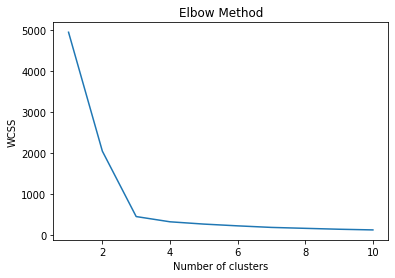

In [0]:
## Decide how many clusters
wcss = [] # within clusters sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(principalDf)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

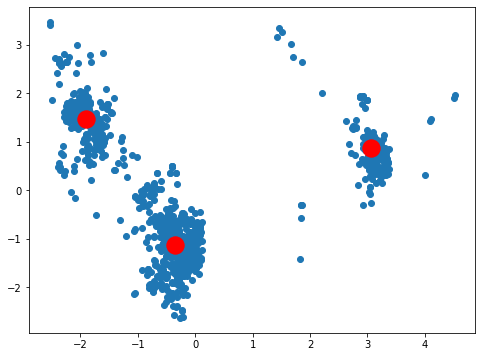

In [0]:
## K means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(principalDf)
plt.figure(figsize=(8,6))
plt.scatter(principalDf.iloc[:,0], principalDf.iloc[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

## Summary
This is a sample data exploration in Elasticsearch with entity keyword == 'Donald Trump' (first 1000 results). I used label encoding to transform the categorical variables into quantitative, reduced dimensionality to 2 with PCA, then tried K-means clustering with 3 clusters. There is a clear cluster structure. However, it is hard to interpret what the result means after dimensionality reduction.

One problem with this data exploration is that I did not use OneHot encoding on categorical variables, so some of the incrementing/decreasing trends we see in some variables might not be meaningful.  

Another problem is that I did not include IP address or article ID, as they are meaningless in clustering. However, this also means that I did not capture actions initiated by the same user or directed at the same article.  